In [3]:
# install setuptools to provide pkg_resources (fix ModuleNotFoundError in Jupyter)
%pip install setuptools
# install pandas
%pip install pandas
# install vnstock
%pip install vnstock

%pip install statsmodels
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [40]:
import json
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
from vnstock import Quote

# Paths
ROOT = Path(__file__).parent if '__file__' in globals() else Path('.')
VN30_JSON = ROOT / 'vn30.json'
OUT_DIR = ROOT
OUT_DIR.mkdir(exist_ok=True)

# Read VN30 symbols from vn30.json
with open(VN30_JSON, 'r', encoding='utf-8') as f:
    vn30 = json.load(f)

# Determine date range: last 30 calendar days (for trading days we still request 30 days and rely on available data)
end_dt = datetime.now()
start_dt = end_dt - timedelta(days=30)
start_str = start_dt.strftime('%Y-%m-%d')
end_str = end_dt.strftime('%Y-%m-%d')
# Safe filename-friendly timestamps (no colons)
start_str_safe = start_dt.strftime('%Y%m%dT%H%M%S')
end_str_safe = end_dt.strftime('%Y%m%dT%H%M%S')

# Helper to fetch a symbol's DataFrame (we'll collect and concat later)
def fetch_symbol_df(symbol):
    q = Quote(symbol=symbol)
    print(f"Fetching {symbol} from {start_str} to {end_str}")
    # interval '1H' requests 1-hour data. vnstock expects interval argument like '1H' (string).
    df = q.history(start=start_str, end=end_str, interval='1H')
    if isinstance(df, pd.DataFrame) and not df.empty:
        # Ensure datetime index where possible
        try:
            df.reset_index(drop=True, inplace=True)
            df = df.reset_index().rename(columns={'index': 'index_col'})
        except Exception:
            pass
        df = df.copy()
        df['stock_symbol'] = symbol
        return df
    else:
        print(f"No data for {symbol} in range {start_str} - {end_str}")
        return None

# vn30 has a fixed structure: 'stocks' is a list of objects with a 'symbol' key
symbols = [entry['symbol'].strip() for entry in vn30['stocks']]

# Fetch sequentially (you can parallelize if desired). Collect DataFrames.
collected = []
for sym in symbols:
    df_sym = fetch_symbol_df(sym)
    if df_sym is not None:
        collected.append(df_sym)

# Concatenate and save one combined CSV
if collected:
    all_df = pd.concat(collected, axis=0, ignore_index=False)
    # If index is datetime, move it to a 'timestamp' column
    try:
        if isinstance(all_df.index, pd.DatetimeIndex):
            all_df = all_df.reset_index().rename(columns={'index': 'timestamp'})
        else:
            all_df = all_df.reset_index().rename(columns={'index': 'timestamp'})
    except Exception:
        all_df = all_df.reset_index().rename(columns={'index': 'timestamp'})

    out_file = OUT_DIR / f"vn30.csv"
    all_df.to_csv(out_file, index=False)
    print(f"Saved combined CSV -> {out_file} (rows={len(all_df)})")
else:
    print("No data collected for any symbol.")

Fetching VCB from 2025-08-19 to 2025-09-18
Fetching VIC from 2025-08-19 to 2025-09-18
Fetching VHM from 2025-08-19 to 2025-09-18
Fetching BID from 2025-08-19 to 2025-09-18
Fetching TCB from 2025-08-19 to 2025-09-18
Fetching CTG from 2025-08-19 to 2025-09-18
Fetching VPB from 2025-08-19 to 2025-09-18
Fetching HPG from 2025-08-19 to 2025-09-18
Fetching GAS from 2025-08-19 to 2025-09-18
Fetching FPT from 2025-08-19 to 2025-09-18
Fetching MBB from 2025-08-19 to 2025-09-18
Fetching GVR from 2025-08-19 to 2025-09-18
Fetching VNM from 2025-08-19 to 2025-09-18
Fetching ACB from 2025-08-19 to 2025-09-18
Fetching MSN from 2025-08-19 to 2025-09-18
Fetching LPB from 2025-08-19 to 2025-09-18
Fetching MWG from 2025-08-19 to 2025-09-18
Fetching STB from 2025-08-19 to 2025-09-18
Fetching HDB from 2025-08-19 to 2025-09-18
Fetching SHB from 2025-08-19 to 2025-09-18
Fetching BCM from 2025-08-19 to 2025-09-18
Fetching SSI from 2025-08-19 to 2025-09-18
Fetching VJC from 2025-08-19 to 2025-09-18
Fetching VR

In [41]:
# Fetch VNINDEX hourly history using vnstock and save to CSV
from vnstock import Quote
from pathlib import Path
import pandas as pd

ROOT = Path('.')
OUT_FILE = ROOT / 'vnindex.csv'

# Specify date range as strings (vnstock expects strings for start/end)
start = '2025-08-19'
end = '2025-09-18'

q = Quote(symbol='VNINDEX')
print(f'Fetching VNINDEX from {start} to {end} (interval=1H)')
df = q.history(start=start, end=end, interval='1H')

if isinstance(df, pd.DataFrame) and not df.empty:
    df = df.reset_index().rename(columns={'index': 'timestamp'})
    df.to_csv(OUT_FILE, index=False)
    print(f'Saved VNINDEX CSV -> {OUT_FILE} (rows={len(df)})')
else:
    print('No VNINDEX data returned for the given range.')

Fetching VNINDEX from 2025-08-19 to 2025-09-18 (interval=1H)
Saved VNINDEX CSV -> vnindex.csv (rows=105)


In [ ]:
# Validate vnindex.csv exists and show basic info
from pathlib import Path
import pandas as pd

ROOT = Path('.')
vn_file = ROOT / 'vnindex.csv'
if vn_file.exists():
    df = pd.read_csv(vn_file, parse_dates=['timestamp'], low_memory=False)
    print('vnindex.csv found: rows=', len(df))
    print('Columns:', df.columns.tolist())
    display(df.head())
else:
    print('vnindex.csv not found. Run the fetch cell first.')

In [46]:
# CAPM regression with proper excess returns calculation
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path

ROOT = Path('.')
vn30_file = ROOT / 'vn30.csv'
vni_file = ROOT / 'vnindex.csv'

# Risk-free rate (VN 5-year bond yield approximation - annualized %)
# You can update this value based on current VN05Y rate
risk_free_annual = 3.0  # 3% annual risk-free rate
risk_free_hourly = (risk_free_annual / 100) / (365 * 24)  # Convert to hourly rate

print(f"Using risk-free rate: {risk_free_annual}% annual, {risk_free_hourly*100:.6f}% hourly")

# Process benchmark market data from vnindex.csv
df_market = pd.read_csv(vni_file)
df_market['time'] = pd.to_datetime(df_market['time']).dt.floor('H')
df_market['close'] = pd.to_numeric(df_market['close'], errors='coerce')
df_market = df_market.dropna(subset=['time', 'close']).sort_values('time')

# Calculate market log returns and excess returns
df_market['market_return'] = np.log(df_market['close']).diff() * 100
df_market['market_excess_return'] = df_market['market_return'] - (risk_free_hourly * 100)
market_returns = df_market[['time', 'market_return', 'market_excess_return']].dropna()

# Process stock data from vn30.csv
df_stocks = pd.read_csv(vn30_file)
df_stocks['time'] = pd.to_datetime(df_stocks['time']).dt.floor('H')
df_stocks['close'] = pd.to_numeric(df_stocks['close'], errors='coerce')
df_stocks = df_stocks.dropna(subset=['time', 'close', 'stock_symbol'])
df_stocks = df_stocks.sort_values(['stock_symbol', 'time'])

# Compute log returns and excess returns for each stock
def compute_stock_returns(group):
    group = group.sort_values('time').copy()
    group['stock_return'] = np.log(group['close']).diff() * 100
    group['stock_excess_return'] = group['stock_return'] - (risk_free_hourly * 100)
    return group

df_stocks = df_stocks.groupby('stock_symbol').apply(compute_stock_returns).reset_index(drop=True)

min_obs = 30
results = []
symbols = df_stocks['stock_symbol'].unique()

print(f"Processing {len(symbols)} stocks...")

# Perform CAPM regression for each stock using excess returns
for symbol in symbols:
    # Get stock data for this symbol
    df_symbol = df_stocks[df_stocks['stock_symbol'] == symbol].dropna(subset=['stock_excess_return'])
    
    # Merge with market data on time
    merged = pd.merge(df_symbol, market_returns, on='time', how='inner')
    merged = merged.dropna(subset=['stock_excess_return', 'market_excess_return'])
    
    n_obs = len(merged)
    
    if n_obs < min_obs:
        results.append({
            'stock_symbol': symbol,
            'alpha': np.nan,
            'beta': np.nan,
            'n_obs': n_obs,
            'status': 'insufficient data'
        })
        continue
    
    # CAPM regression: Stock_excess_return = alpha + beta * Market_excess_return + error
    y = merged['stock_excess_return']  # Dependent variable (stock excess returns)
    x = merged['market_excess_return']  # Independent variable (market excess returns)
    X = sm.add_constant(x)  # Add intercept
    
    try:
        model = sm.OLS(y, X).fit()
        alpha = model.params.get('const', np.nan)  # Alpha (intercept)
        beta = model.params.iloc[1] if len(model.params) > 1 else np.nan  # Beta (slope)
        
        results.append({
            'stock_symbol': symbol,
            'alpha': alpha,
            'beta': beta,
            'n_obs': int(model.nobs),
            'r_squared': model.rsquared,
            'status': 'ok'
        })
        
    except Exception as e:
        results.append({
            'stock_symbol': symbol,
            'alpha': np.nan,
            'beta': np.nan,
            'n_obs': n_obs,
            'r_squared': np.nan,
            'status': f'error: {str(e)}'
        })

# Save results
results_df = pd.DataFrame(results).sort_values('stock_symbol')
output_file = ROOT / 'capm_results.csv'
results_df.to_csv(output_file, index=False)

print(f"CAPM results saved to {output_file}")
print(f"Processed {len(results_df)} stocks")
print(f"Successful calculations: {len(results_df[results_df['status'] == 'ok'])}")

# Display results sorted by alpha (descending)
display_df = results_df[results_df['status'] == 'ok'].sort_values('alpha', ascending=False)
print(f"\nTop 10 stocks by alpha:")
display_df.head(10)

Using risk-free rate: 3.0% annual, 0.000342% hourly
Processing 30 stocks...
CAPM results saved to capm_results.csv
Processed 30 stocks
Successful calculations: 30

Top 10 stocks by alpha:


'H' is deprecated and will be removed in a future version, please use 'h' instead.
'H' is deprecated and will be removed in a future version, please use 'h' instead.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,stock_symbol,alpha,beta,n_obs,r_squared,status
25,VIC,0.193902,0.612513,104,0.088999,ok
13,MWG,0.118304,1.249003,104,0.478820,ok
18,SSI,0.108724,1.820918,104,0.543963,ok
23,VHM,0.103558,0.675845,104,0.122106,ok
10,LPB,0.076470,1.548722,104,0.346317,ok
19,STB,0.064763,1.345485,104,0.435099,ok
27,VNM,0.042787,0.434580,104,0.159693,ok
4,CTG,0.028047,1.167237,104,0.526275,ok
29,VRE,0.023976,0.622590,104,0.157061,ok
9,HPG,0.020488,0.994673,104,0.330219,ok


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


CAPM plots saved to capm_plots.png


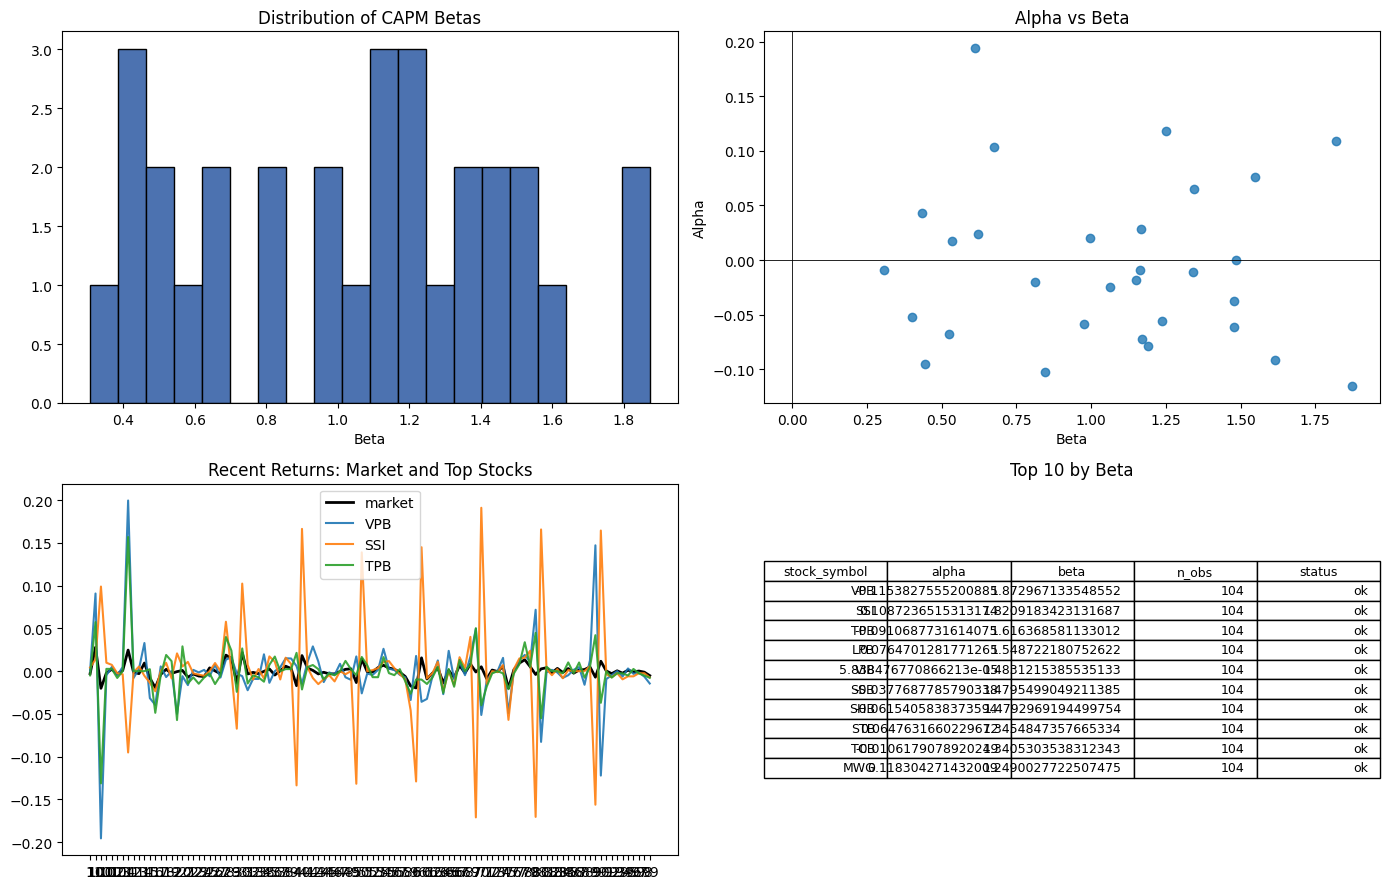

In [47]:
# Plot CAPM diagnostics: beta distribution, alpha vs beta, recent returns for top stocks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path('.')
res_file = ROOT / 'capm_results.csv'
if not res_file.exists():
    raise FileNotFoundError(f"Expected {res_file} to exist. Run the CAPM computation cell first.")

res = pd.read_csv(res_file)

if res.empty:
    print('No CAPM results to plot')
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    axes = axes.flatten()

    # 1) Histogram of betas
    betas = res['beta'].dropna()
    axes[0].hist(betas, bins=20, color='#4C72B0', edgecolor='k')
    axes[0].set_title('Distribution of CAPM Betas')
    axes[0].set_xlabel('Beta')

    # 2) Alpha vs Beta scatter
    axes[1].scatter(res['beta'], res['alpha'], alpha=0.8)
    axes[1].axvline(0, color='k', linewidth=0.6)
    axes[1].axhline(0, color='k', linewidth=0.6)
    axes[1].set_xlabel('Beta')
    axes[1].set_ylabel('Alpha')
    axes[1].set_title('Alpha vs Beta')

    # 3) Recent returns: market and top 3 by |beta|
    ok = res[res['status'] == 'ok'].dropna(subset=['beta'])
    if not ok.empty:
        top = ok.loc[ok['beta'].abs().sort_values(ascending=False).index].head(3)['stock_symbol'].tolist()
        # load vn30 prices and compute log returns
        price_csv = ROOT / 'vn30.csv'
        if price_csv.exists():
            df = pd.read_csv(price_csv, parse_dates=['timestamp'])
            price = df[['timestamp', 'stock_symbol', 'close']].pivot_table(index='timestamp', columns='stock_symbol', values='close')
            price = price.sort_index()
            returns = np.log(price).diff()
            market = returns.mean(axis=1)
            recent_index = market.dropna().index
            if len(recent_index) == 0:
                axes[2].text(0.5, 0.5, 'No return data to plot', ha='center')
            else:
                idx = recent_index[-200:] if len(recent_index) > 200 else recent_index
                axes[2].plot(market.loc[idx].index, market.loc[idx].values, label='market', linewidth=2, color='k')
                for s in top:
                    if s in returns.columns:
                        axes[2].plot(returns.loc[idx].index, returns.loc[idx, s].values, label=s, alpha=0.9)
                axes[2].legend()
                axes[2].set_title('Recent Returns: Market and Top Stocks')
        else:
            axes[2].text(0.5, 0.5, 'vn30.csv not found, cannot plot returns', ha='center')
    else:
        axes[2].text(0.5, 0.5, 'No stocks with valid beta to plot', ha='center')

    # 4) Summary table (show top rows)
    axes[3].axis('off')
    sample = res.sort_values('beta', ascending=False).head(10)[['stock_symbol', 'alpha', 'beta', 'n_obs', 'status']]
    table = axes[3].table(cellText=sample.values, colLabels=sample.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    axes[3].set_title('Top 10 by Beta')

    plt.tight_layout()
    out_fig = ROOT / 'capm_plots.png'
    plt.savefig(out_fig, dpi=150)
    print(f'CAPM plots saved to {out_fig}')
    plt.show()

In [ ]:
# Advanced Portfolio Analysis with Efficient Frontier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Use available matplotlib styles
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        pass  # Use default style

ROOT = Path('.')

# Load data for efficient frontier calculation
vn30_file = ROOT / 'vn30.csv'
capm_file = ROOT / 'capm_results.csv'

if not vn30_file.exists() or not capm_file.exists():
    print("Required data files not found. Please run previous cells first.")
else:
    # Load stock price data and calculate returns
    df_stocks = pd.read_csv(vn30_file)
    df_stocks['time'] = pd.to_datetime(df_stocks['time'])
    df_stocks = df_stocks.dropna(subset=['close', 'stock_symbol'])
    
    # Create price pivot table
    price_pivot = df_stocks.pivot_table(
        index='time', 
        columns='stock_symbol', 
        values='close'
    ).sort_index()
    
    # Calculate daily returns (convert hourly to daily)
    daily_prices = price_pivot.resample('D').last().dropna()
    daily_returns = daily_prices.pct_change().dropna()
    
    # Filter stocks with sufficient data
    min_periods = 20
    valid_stocks = daily_returns.columns[daily_returns.count() >= min_periods]
    daily_returns = daily_returns[valid_stocks]
    
    print(f"Analyzing {len(valid_stocks)} stocks with sufficient data")
    
    # Calculate annualized statistics
    trading_days = 252
    mean_returns = daily_returns.mean() * trading_days
    cov_matrix = daily_returns.cov() * trading_days
    
    # Load CAPM results
    capm_results = pd.read_csv(capm_file)
    capm_results = capm_results[capm_results['status'] == 'ok']
    
    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. CAPM Alpha vs Beta with stock labels
    ax1 = plt.subplot(3, 3, 1)
    scatter = ax1.scatter(capm_results['beta'], capm_results['alpha'], 
                         c=capm_results['r_squared'], cmap='viridis', alpha=0.7, s=50)
    
    # Add labels for extreme alpha stocks
    for _, row in capm_results.nlargest(3, 'alpha').iterrows():
        ax1.annotate(row['stock_symbol'], (row['beta'], row['alpha']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    for _, row in capm_results.nsmallest(3, 'alpha').iterrows():
        ax1.annotate(row['stock_symbol'], (row['beta'], row['alpha']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax1.axhline(0, color='red', linestyle='--', alpha=0.5)
    ax1.axvline(1, color='red', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Beta')
    ax1.set_ylabel('Alpha (%)')
    ax1.set_title('CAPM Alpha vs Beta (colored by R²)')
    plt.colorbar(scatter, ax=ax1, label='R²')
    
    # 2. Risk-Return Scatter - Fix indexing issue
    ax2 = plt.subplot(3, 3, 2)
    volatility = pd.Series(np.sqrt(np.diag(cov_matrix)), index=cov_matrix.index)  # Make it a Series
    ax2.scatter(volatility, mean_returns, alpha=0.7)
    
    # Add labels for high/low return stocks
    top_returns = mean_returns.nlargest(3)
    for stock in top_returns.index:
        if stock in volatility.index:  # Check if stock exists in volatility
            ax2.annotate(stock, (volatility[stock], mean_returns[stock]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Volatility (Annualized)')
    ax2.set_ylabel('Expected Return (Annualized)')
    ax2.set_title('Risk-Return Profile')
    ax2.grid(True, alpha=0.3)
    
    # 3. Efficient Frontier Calculation and Plot
    ax3 = plt.subplot(3, 3, 3)
    
    def portfolio_performance(weights, mean_returns, cov_matrix):
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_return, portfolio_volatility
    
    def minimize_volatility(mean_returns, cov_matrix, target_return):
        n_assets = len(mean_returns)
        
        def portfolio_volatility(weights):
            return portfolio_performance(weights, mean_returns, cov_matrix)[1]
        
        constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - target_return},
                      {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for _ in range(n_assets))
        initial_guess = n_assets * [1. / n_assets]
        
        result = minimize(portfolio_volatility, initial_guess, method='SLSQP', 
                         bounds=bounds, constraints=constraints)
        return result
    
    # Calculate efficient frontier
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 30)  # Reduce points for stability
    efficient_portfolios = []
    
    for target in target_returns:
        try:
            result = minimize_volatility(mean_returns, cov_matrix, target)
            if result.success:
                ret, vol = portfolio_performance(result.x, mean_returns, cov_matrix)
                efficient_portfolios.append([ret, vol])
        except:
            continue
    
    if efficient_portfolios:
        efficient_portfolios = np.array(efficient_portfolios)
        
        # Plot efficient frontier
        ax3.plot(efficient_portfolios[:, 1], efficient_portfolios[:, 0], 
                'b-', linewidth=2, label='Efficient Frontier')
        
        # Plot individual stocks
        ax3.scatter(volatility, mean_returns, alpha=0.5, label='Individual Stocks')
        
        # Calculate and plot market portfolio (equal weights)
        equal_weights = np.array([1/len(mean_returns)] * len(mean_returns))
        market_return, market_vol = portfolio_performance(equal_weights, mean_returns, cov_matrix)
        ax3.scatter(market_vol, market_return, color='red', s=100, marker='*', 
                   label='Equal Weight Portfolio')
        
        # Calculate and plot minimum variance portfolio
        def minimize_variance(mean_returns, cov_matrix):
            n_assets = len(mean_returns)
            
            def portfolio_volatility(weights):
                return portfolio_performance(weights, mean_returns, cov_matrix)[1]
            
            constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            bounds = tuple((0, 1) for _ in range(n_assets))
            initial_guess = n_assets * [1. / n_assets]
            
            result = minimize(portfolio_volatility, initial_guess, method='SLSQP', 
                             bounds=bounds, constraints=constraints)
            return result
        
        try:
            min_var_result = minimize_variance(mean_returns, cov_matrix)
            if min_var_result.success:
                min_var_return, min_var_vol = portfolio_performance(min_var_result.x, mean_returns, cov_matrix)
                ax3.scatter(min_var_vol, min_var_return, color='green', s=100, marker='*', 
                           label='Min Variance Portfolio')
        except:
            print("Could not calculate minimum variance portfolio")
    
    ax3.set_xlabel('Volatility (Annualized)')
    ax3.set_ylabel('Expected Return (Annualized)')
    ax3.set_title('Efficient Frontier')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Beta Distribution
    ax4 = plt.subplot(3, 3, 4)
    ax4.hist(capm_results['beta'], bins=20, alpha=0.7, edgecolor='black')
    ax4.axvline(1, color='red', linestyle='--', label='Market Beta = 1')
    ax4.set_xlabel('Beta')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Beta Values')
    ax4.legend()
    
    # 5. Alpha Distribution
    ax5 = plt.subplot(3, 3, 5)
    ax5.hist(capm_results['alpha'], bins=20, alpha=0.7, edgecolor='black')
    ax5.axvline(0, color='red', linestyle='--', label='Alpha = 0')
    ax5.set_xlabel('Alpha (%)')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Distribution of Alpha Values')
    ax5.legend()
    
    # 6. Correlation Heatmap (top 10 stocks by market cap)
    ax6 = plt.subplot(3, 3, 6)
    top_10_stocks = daily_returns.iloc[:, :min(10, len(daily_returns.columns))]  # Ensure we don't exceed available stocks
    correlation_matrix = top_10_stocks.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', ax=ax6, cbar_kws={'shrink': 0.8})
    ax6.set_title('Correlation Matrix (Top 10 Stocks)')
    
    # 7. Rolling Beta for top alpha stock
    ax7 = plt.subplot(3, 3, 7)
    if len(capm_results) > 0:
        top_alpha_stock = capm_results.loc[capm_results['alpha'].idxmax(), 'stock_symbol']
        if top_alpha_stock in daily_returns.columns:
            # Calculate rolling 30-day beta
            market_returns_daily = daily_returns.mean(axis=1)  # Equal weight market proxy
            stock_returns = daily_returns[top_alpha_stock]
            
            rolling_window = 30
            rolling_beta = []
            rolling_dates = []
            
            for i in range(rolling_window, len(stock_returns)):
                y = stock_returns.iloc[i-rolling_window:i]
                x = market_returns_daily.iloc[i-rolling_window:i]
                
                if len(y.dropna()) > 10 and len(x.dropna()) > 10:
                    try:
                        covariance = np.cov(y.dropna(), x.dropna())[0, 1]
                        market_variance = np.var(x.dropna())
                        if market_variance > 0:
                            beta = covariance / market_variance
                            rolling_beta.append(beta)
                            rolling_dates.append(stock_returns.index[i])
                    except:
                        continue
            
            if rolling_beta:
                ax7.plot(rolling_dates, rolling_beta, linewidth=1)
                ax7.axhline(1, color='red', linestyle='--', alpha=0.5)
                ax7.set_title(f'Rolling 30-Day Beta: {top_alpha_stock}')
                ax7.set_ylabel('Beta')
                ax7.tick_params(axis='x', rotation=45)
            else:
                ax7.text(0.5, 0.5, 'Insufficient data for rolling beta', ha='center', va='center')
        else:
            ax7.text(0.5, 0.5, 'Top alpha stock not in price data', ha='center', va='center')
    else:
        ax7.text(0.5, 0.5, 'No CAPM results available', ha='center', va='center')
    
    # 8. Sharpe Ratio Rankings
    ax8 = plt.subplot(3, 3, 8)
    risk_free_rate = 0.03  # 3% risk-free rate
    sharpe_ratios = (mean_returns - risk_free_rate) / volatility
    top_sharpe = sharpe_ratios.nlargest(10)
    
    if len(top_sharpe) > 0:
        bars = ax8.barh(range(len(top_sharpe)), top_sharpe.values)
        ax8.set_yticks(range(len(top_sharpe)))
        ax8.set_yticklabels(top_sharpe.index)
        ax8.set_xlabel('Sharpe Ratio')
        ax8.set_title('Top 10 Stocks by Sharpe Ratio')
        ax8.grid(axis='x', alpha=0.3)
        
        # Color bars based on value
        for i, bar in enumerate(bars):
            if top_sharpe.values[i] > 0:
                bar.set_color('green')
            else:
                bar.set_color('red')
    else:
        ax8.text(0.5, 0.5, 'No Sharpe ratio data', ha='center', va='center')
    
    # 9. Performance Summary Table
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Create summary statistics
    try:
        summary_data = {
            'Metric': ['Total Stocks', 'Avg Alpha', 'Avg Beta', 'Avg R²', 
                      'High Alpha Stocks (>1%)', 'Low Beta Stocks (<0.8)', 'High Beta Stocks (>1.2)'],
            'Value': [
                len(capm_results),
                f"{camp_results['alpha'].mean():.3f}%",
                f"{capm_results['beta'].mean():.3f}",
                f"{camp_results['r_squared'].mean():.3f}",
                len(capm_results[capm_results['alpha'] > 1]),
                len(capm_results[camp_results['beta'] < 0.8]),
                len(capm_results[capm_results['beta'] > 1.2])
            ]
        }
        
        summary_df = pd.DataFrame(summary_data)
        table = ax9.table(cellText=summary_df.values, colLabels=summary_df.columns,
                         cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        ax9.set_title('Portfolio Analysis Summary', y=0.95)
    except Exception as e:
        ax9.text(0.5, 0.5, f'Error creating summary: {str(e)}', ha='center', va='center')
    
    plt.tight_layout()
    
    # Save the comprehensive plot
    output_path = ROOT / 'portfolio_analysis_comprehensive.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Comprehensive portfolio analysis saved to: {output_path}")
    
    plt.show()
    
    # Print key insights
    print("\n" + "="*50)
    print("KEY PORTFOLIO INSIGHTS")
    print("="*50)
    
    try:
        if len(capm_results) > 0:
            print(f"Best Alpha: {capm_results.loc[capm_results['alpha'].idxmax(), 'stock_symbol']} "
                  f"({capm_results['alpha'].max():.3f}%)")
            print(f"Worst Alpha: {capm_results.loc[capm_results['alpha'].idxmin(), 'stock_symbol']} "
                  f"({capm_results['alpha'].min():.3f}%)")
            print(f"Highest Beta: {capm_results.loc[capm_results['beta'].idxmax(), 'stock_symbol']} "
                  f"({capm_results['beta'].max():.3f})")
            print(f"Lowest Beta: {capm_results.loc[capm_results['beta'].idxmin(), 'stock_symbol']} "
                  f"({capm_results['beta'].min():.3f})")
        
        if len(sharpe_ratios) > 0:
            best_sharpe = sharpe_ratios.idxmax()
            print(f"Best Sharpe Ratio: {best_sharpe} ({sharpe_ratios[best_sharpe]:.3f})")
        
        if len(correlation_matrix) > 1:
            upper_tri = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
            print(f"Average Portfolio Correlation: {upper_tri.mean():.3f}")
    except Exception as e:
        print(f"Error printing insights: {str(e)}")

Analyzing 30 stocks with sufficient data


NameError: name 'camp_results' is not defined